### Working with Data, Part II

In this notebook we will process raw spiking data collected from recordings made in CA1 during open field foraging experiments. We will attempt to uncover structure in these cells.  

All data are from the [hc-2 dataset](https://crcns.org/data-sets/hc/hc-2/about-hc-2) found on the [CRCNS website](https://crcns.org), as are instructions on how to cite the data in a publication. A free CRCNS account is required in order to download.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib import cm

In [3]:
directories = ['data/crcns/hc2/ec013.527', # food reward
               'data/crcns/hc2/ec013.529'] # water reward
n_shanks = 4

#### Load spike times

In [4]:
cluster = [np.fromfile(os.path.join(directories[0],'ec013.527.clu.%d'%(n+1)), dtype=np.int8, sep='\r')[:-1] 
           for n in range(n_shanks)]

times   = [np.fromfile(os.path.join(directories[0],'ec013.527.res.%d'%(n+1)), dtype=np.int, sep='\r') 
           for n in range(n_shanks)]

In [5]:
units = [times[n][cluster[n] == i] for n in range(n_shanks) 
                                   for i in range(2,cluster[n].max())]

In [6]:
[(n, u.size) for n,u in enumerate(units)]

[(0, 271),
 (1, 25),
 (2, 7),
 (3, 0),
 (4, 19),
 (5, 23),
 (6, 279),
 (7, 0),
 (8, 1),
 (9, 158),
 (10, 1512),
 (11, 1),
 (12, 7),
 (13, 94),
 (14, 436),
 (15, 3),
 (16, 0),
 (17, 31494),
 (18, 99),
 (19, 60),
 (20, 0),
 (21, 69),
 (22, 42),
 (23, 559),
 (24, 0),
 (25, 244),
 (26, 1913),
 (27, 223),
 (28, 403),
 (29, 8426),
 (30, 32434),
 (31, 767),
 (32, 14),
 (33, 172),
 (34, 760),
 (35, 24),
 (36, 895),
 (37, 793),
 (38, 67),
 (39, 7158),
 (40, 1820),
 (41, 4129)]

#### Raster plot of unit activity

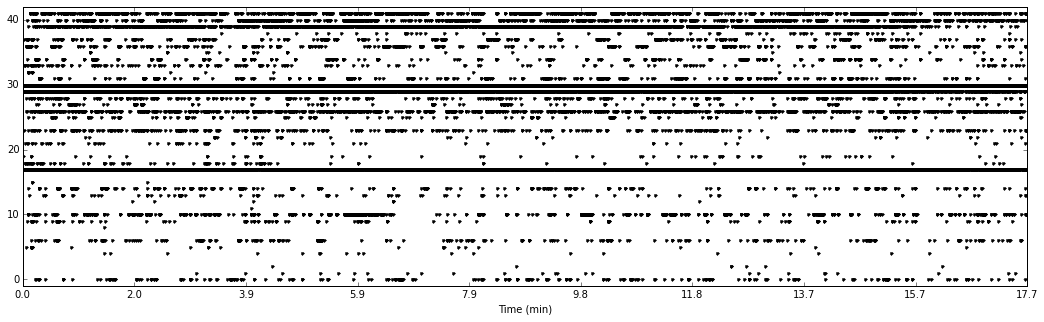

In [8]:
d = np.hstack([np.array([np.full(u.size, fill_value=n, dtype=np.int64), u]) for n,u in enumerate(units)])
plt.figure(figsize=(18,5))
plt.plot(d[1],d[0],'.k');
plt.ylim([-1,42]);
plt.xlim([0,d[1].max()]);
plt.xticks(np.linspace(0,d[1].max(),10), np.round(np.linspace(0,d[1].max()/20000./60.,10),1));
plt.xlabel('Time (min)');

#### Load open field data

In [10]:
led_path = np.loadtxt(os.path.join(directories[0],'ec013.527.whl'))
led_times = np.arange(led_path.shape[0])*(1./39.06 * 20000/1.) # Units of 1/20000 sec
led_path = np.concatenate([led_path[:,:2], led_times[:,np.newaxis]], axis=1)
led_path = np.ma.masked_equal(led_path, -1)
led_path = np.ma.compress_rows(led_path)

#### Plot trajectory of mouse

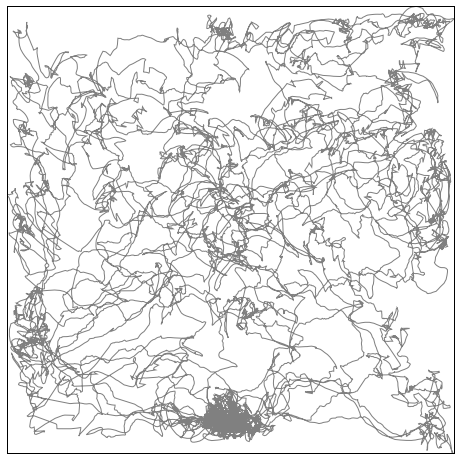

In [11]:
verts = np.ma.compress_rows(led_path)[:,:2]
codes = [Path.MOVETO] + [Path.LINETO]*(verts.shape[0]-1)
path = Path(verts, codes)

f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)
patch = patches.PathPatch(path, facecolor='none', edgecolor='grey', lw=1)
ax.add_patch(patch)
ax.set_xlim(verts[:,0].min(),verts[:,0].max());
ax.set_ylim(verts[:,1].min(),verts[:,1].max());
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

#### Plot place field for selected neurons

In [12]:
start_t, stop_t = led_path[0,-1], led_path[-1,-1]
valid_units = [u[np.logical_and(u > start_t, u < stop_t)] for u in units]
interp_xy = interp1d(x=led_path[:,-1], y=verts[:,:], axis=0)

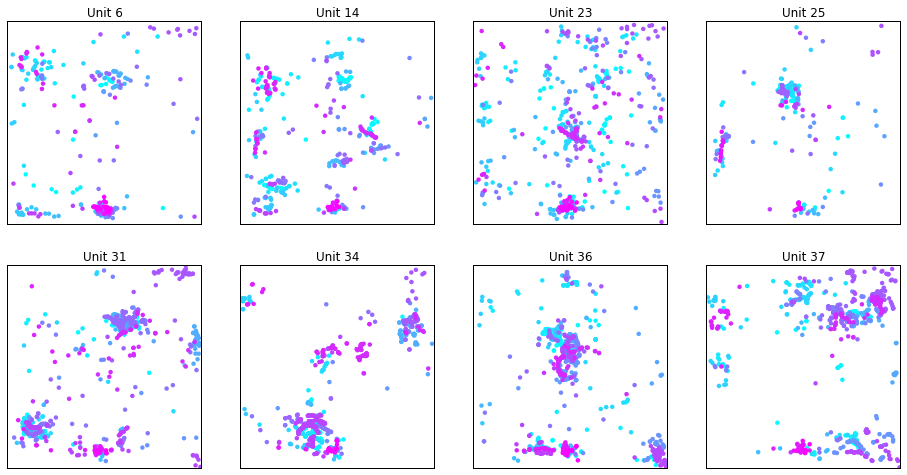

In [14]:
idxs = [6,14,23,25,31,34,36,37]
f2, ax2 = plt.subplots(2, 4, figsize=(16,8), )
for ax,i in zip(ax2.flatten(),idxs):
    coords = interp_xy(valid_units[i])
    ax.scatter(x=coords[:,0], y=coords[:,1], c=valid_units[i], cmap='cool', linewidths=0);
    ax.set_xlim(verts[:,0].min(),verts[:,0].max());
    ax.set_ylim(verts[:,1].min(),verts[:,1].max());
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title('Unit %d'%i)